In [1]:
import sys
sys.path.append('..')
from scipy import stats
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import copy
from nestedness_calculator import NestednessCalculator
import vis_function as vf
import warnings
import scipy.stats
import os
from copy import deepcopy as dc
import matplotlib.pyplot as plt
import json
import network_util
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

warnings.filterwarnings('ignore')

def nestedness(input_df, cutoff, outdir):
    unique_fr = []
    for i in range(input_df.shape[0]):
        for j in range(i+1, input_df.shape[0]):
            if input_df.iloc[i, j] > 0:
                unique_fr.append(input_df.iloc[i,j])
    if len(unique_fr) > 2:
        p_value = scipy.stats.normaltest(unique_fr)[1]
        print("p_value is {}, normal {}".format(p_value, p_value>0.05))
    xtitle = 'distribution'
    vf.fr_frequency(input_df.values, xtitle, os.path.join(outdir, 'freq.pdf'))
    miu = np.mean(unique_fr)
    sigma = np.std(unique_fr)
    vf.heatmap_fr_continue(input_df, 'matrix', os.path.join(outdir, 'contin_matrix.pdf'))
    binary_df = vf.heatmap_fr_binary(input_df, 'binary matrix', cutoff, os.path.join(outdir, 'binary_matrix.pdf'))
    #print(binary_df)
    nested_nodf_score = NestednessCalculator(binary_df.values).nodf(binary_df.values)
    print("NODF = {}".format(nested_nodf_score))

    # NULL model 100 times
    a=stats.norm.rvs(miu,sigma,size=len(unique_fr))
    scores = []
    for i in range(100):
        pos_list=random.sample(list(range(0, int((input_df.shape[0]**2-input_df.shape[0])/2))), len(unique_fr))
        pos_list.sort()
        empty = np.zeros(shape = input_df.shape)
        pos_idx = 0
        idx = 0
        for i in range(empty.shape[0]):
            if pos_idx == len(pos_list):
                break
            for j in range(i+1, empty.shape[0]):
                if pos_idx == len(pos_list):
                    break
                elif idx == pos_list[pos_idx]:
                    empty[i][j] = a[pos_idx]
                    pos_idx += 1
                idx += 1 
        empty += empty.T
        row, col = np.diag_indices_from(empty)
        empty[row, col] = 1
        empty_df = pd.DataFrame(empty)
        binary_empty = vf.cutoff_matrix(empty_df, cutoff)
        nodf_score = NestednessCalculator(binary_empty.values).nodf(binary_empty.values)
        scores.append(nodf_score)

    # visualize the last null model
    vf.heatmap_fr_continue(empty_df, 'null model', os.path.join(outdir, 'null_model.pdf'))
    vf.heatmap_fr_binary(empty_df, 'null model binary', cutoff, os.path.join(outdir, 'binary_null.pdf'))
    print("last null model NODF = {}".format(nodf_score))
    t, p = scipy.stats.ttest_1samp(scores, nested_nodf_score)
    print("p value = {}".format(p))
    return scores, nested_nodf_score, p

p_value is 5.3264739336336695e-71, normal False


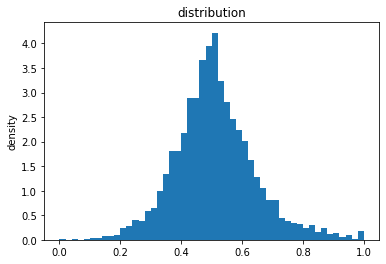

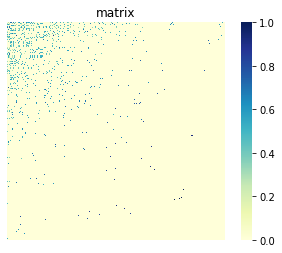

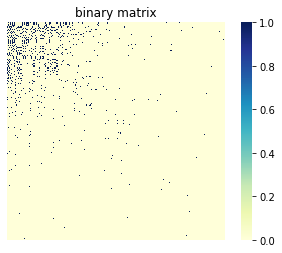

NODF = 0.06119976079727655


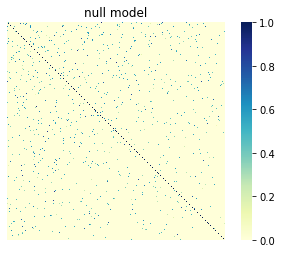

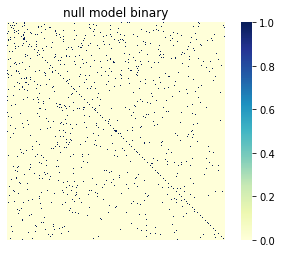

last null model NODF = 0.01974759152806239
p value = 3.98301140519507e-242


([0.019793760252030827,
  0.019496923328310444,
  0.019522660800624203,
  0.019679591141313568,
  0.019642665423535904,
  0.019648492745864127,
  0.019434188238783238,
  0.01947891841641622,
  0.019427948652631685,
  0.019510954308578934,
  0.01955358354761336,
  0.019622285912452485,
  0.019280962178924367,
  0.01975192767886115,
  0.019676418045408716,
  0.01934357397625016,
  0.01950561633955387,
  0.019680243485111482,
  0.019638104508298906,
  0.019886812432685304,
  0.01942970826652603,
  0.019338872757684533,
  0.019593752560041908,
  0.01996306312303927,
  0.019326295094973966,
  0.019566094963159763,
  0.019748924460151134,
  0.01944926220059163,
  0.01956643090345563,
  0.019665169511941076,
  0.019353672603377562,
  0.019713885032608312,
  0.01971429139960695,
  0.019469321143191,
  0.01955249778121037,
  0.01936839928328287,
  0.019344200992318317,
  0.01962276003619223,
  0.019314529277719695,
  0.01947610986930945,
  0.019626379895695305,
  0.01979276344175255,
  0.019557

In [2]:
binary_cutoff = 0.3
idir = '../result/S1_plasmid_net/feature'
odir = '../result/S1_plasmid_net/nestedness'
if not os.path.exists(odir):
    os.makedirs(odir)


ipath = os.path.join(idir, 'degree_norm.tsv')
undirected = pd.read_csv(ipath, sep='\t', header=0, index_col=0)
#df_norm = simple_normalized(undirected)
df_norm = network_util.log_rescale(undirected)
df_norm = df_norm.loc[:, (df_norm != 0).any(axis=0)]
df_norm = df_norm.loc[(df_norm != 0).any(axis=1), :]
opath = os.path.join(idir, 'log_rescale.tsv')
df_norm.to_csv(opath, sep='\t')
nestedness(df_norm, binary_cutoff, odir)
